# Fake News Detection

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

## Read Datasets

In [2]:
fake_df = pd.read_csv("data/Fake.csv")
real_df = pd.read_csv("data/True.csv")

In [3]:
print(fake_df.shape)

(23481, 4)


In [4]:
print(real_df.shape)

(21417, 4)


## Data Preparation

In [5]:
# Add flag to track fake and real
fake_df["target"] = "fake"
real_df["target"] = "real"

In [6]:
# Concatenate fake and real dataframes
df = pd.concat([fake_df, real_df]).reset_index(drop=True)
print(df.shape)

(44898, 5)


In [7]:
# Shuffle data
from sklearn.utils import shuffle

df = shuffle(df)
df = df.reset_index(drop=True)
print(df.head())

                                               title  \
0  BOOM! FIRST ANTIFA Coward ARRESTED For Not Rem...   
1   Detroit Mayor Blasts Trump’s ‘Phony’ Black Ch...   
2   In Unprecedented Endorsement, Non-Partisan Hu...   
3  THIS PICTURE OF HARRIET TUBMAN Should Be Used ...   
4  BREAKING LIVE FEED: POLICE FORM LARGE BARRICAD...   

                                                text    subject  \
0  The video below is an excellent summary of wha...  left-news   
1  Donald Trump, knowing that his poll numbers wi...       News   
2  The Humane Society of the United States pretty...       News   
3  Obama has filled his cabinet with radical  yes...  left-news   
4  A large group of Black Lives Matter protesters...   politics   

                date target  
0       Apr 27, 2017   fake  
1  September 4, 2016   fake  
2   October 11, 2016   fake  
3       Apr 21, 2016   fake  
4        Jul 8, 2016   fake  


In [8]:
# Remove title & date column
df.drop(["title", "date"], axis=1, inplace=True)
print(df.head())

                                                text    subject target
0  The video below is an excellent summary of wha...  left-news   fake
1  Donald Trump, knowing that his poll numbers wi...       News   fake
2  The Humane Society of the United States pretty...       News   fake
3  Obama has filled his cabinet with radical  yes...  left-news   fake
4  A large group of Black Lives Matter protesters...   politics   fake


## Data Cleaning

In [9]:
df.dropna(subset=["text"], inplace=True)
df.reset_index(drop=True, inplace=True)

In [10]:
# Convert to lowercase
df["text"] = df["text"].str.lower()
print(df.head())

                                                text    subject target
0  the video below is an excellent summary of wha...  left-news   fake
1  donald trump, knowing that his poll numbers wi...       News   fake
2  the humane society of the united states pretty...       News   fake
3  obama has filled his cabinet with radical  yes...  left-news   fake
4  a large group of black lives matter protesters...   politics   fake


In [11]:
# Remove numbers, punctuations and extra spaces
df["text"] = df["text"].str.replace(r"[^a-zA-Z\s]", "", regex=True)
df["text"] = df["text"].str.replace(r"\s+", " ", regex=True)
df["text"] = df["text"].str.strip()
print(df.head())

                                                text    subject target
0  the video below is an excellent summary of wha...  left-news   fake
1  donald trump knowing that his poll numbers wit...       News   fake
2  the humane society of the united states pretty...       News   fake
3  obama has filled his cabinet with radical yes ...  left-news   fake
4  a large group of black lives matter protesters...   politics   fake


In [12]:
# Remove stopwords
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stopwords_ = stopwords.words("english")

df["text"] = df["text"].apply(lambda x: " ".join([word for word in x.split() if word not in stopwords_]))
print(df.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kdnin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text    subject target
0  video excellent summary reported citizen journ...  left-news   fake
1  donald trump knowing poll numbers black voters...       News   fake
2  humane society united states pretty much never...       News   fake
3  obama filled cabinet radical yes men women hol...  left-news   fake
4  large group black lives matter protesters marc...   politics   fake


## Basic Data Exploration

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: text, dtype: int64


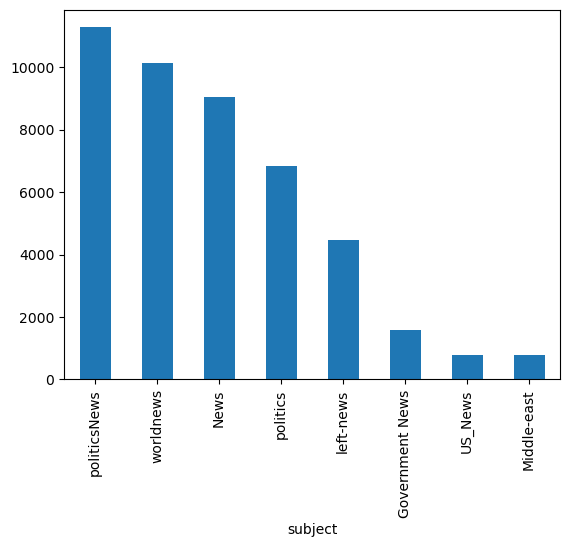

In [13]:
# How many articles per subject?
articles_subject_count = df.groupby(["subject"])["text"] \
    .count() \
    .sort_values(ascending=False)

print(articles_subject_count)
articles_subject_count.plot(kind="bar")
plt.show()

target
fake    23481
real    21417
Name: text, dtype: int64


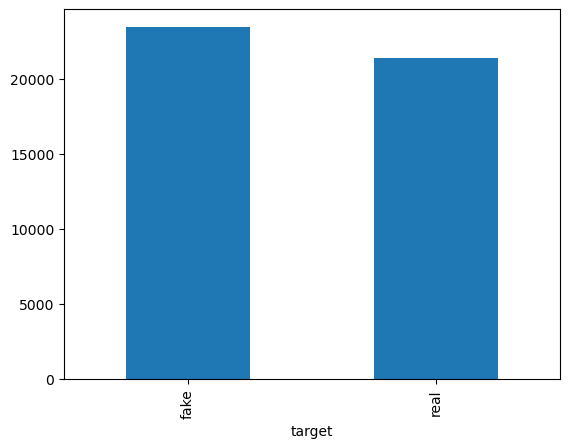

In [14]:
# How many fake and real articles?
articles_types_count = df.groupby(["target"])["text"].count()

print(articles_types_count)
articles_types_count.plot(kind="bar")
plt.show()

In [15]:
from wordcloud import WordCloud


def show_wordcloud(text):
    wordcloud = WordCloud(
        width=800,
        height=500,
        max_font_size=110,
        collocations=False
    ).generate(text)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [16]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)
import nltk
import seaborn as sns
from nltk.tokenize import WhitespaceTokenizer


def show_frequent_words(text, quantity):
    tokens = WhitespaceTokenizer().tokenize(text)
    frequency = nltk.FreqDist(tokens)

    frequency_df = pd.DataFrame(
        data=frequency.items(),
        columns=["Word", "Frequency"]
    )
    frequency_df = frequency_df.nlargest(columns="Frequency", n=quantity)

    plt.figure(figsize=(11, 8))
    ax = sns.barplot(data=frequency_df, x="Word", y="Frequency", color="blue")
    ax.set(ylabel="Count")
    plt.xticks(rotation="vertical")
    plt.show()

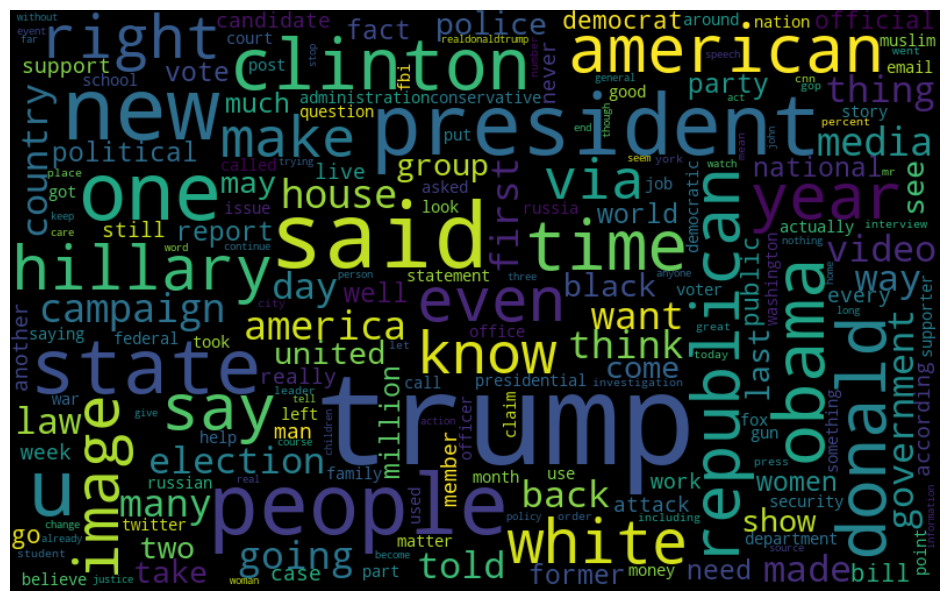

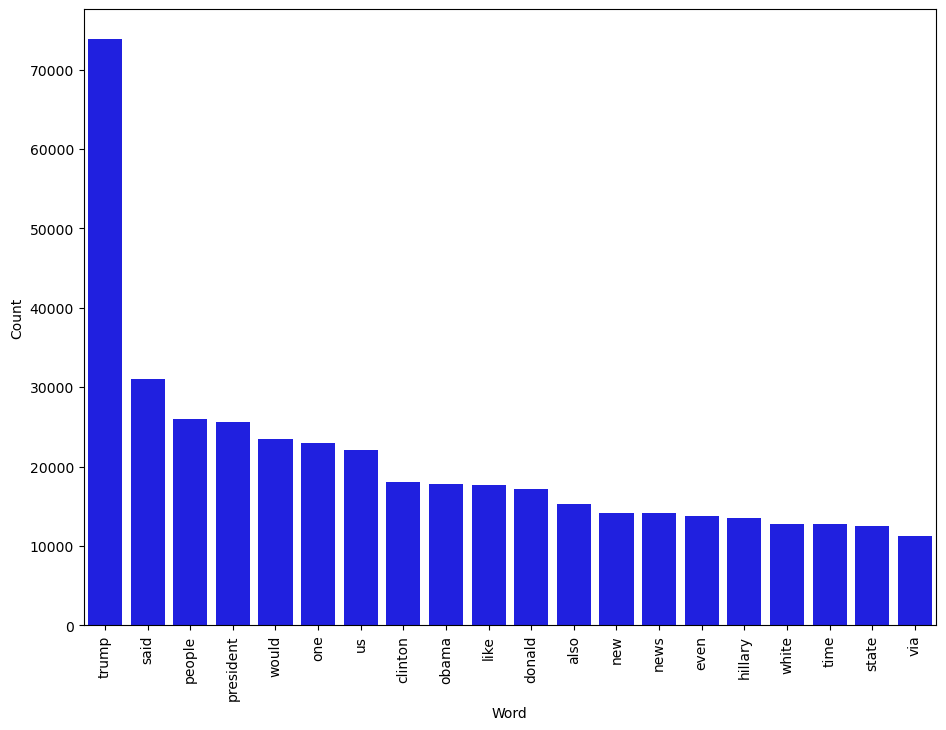

In [17]:
# Word cloud and most frequent words for fake news
text = " ".join(df[df["target"] == "fake"]["text"].to_list())

show_wordcloud(text)
show_frequent_words(text, 20)

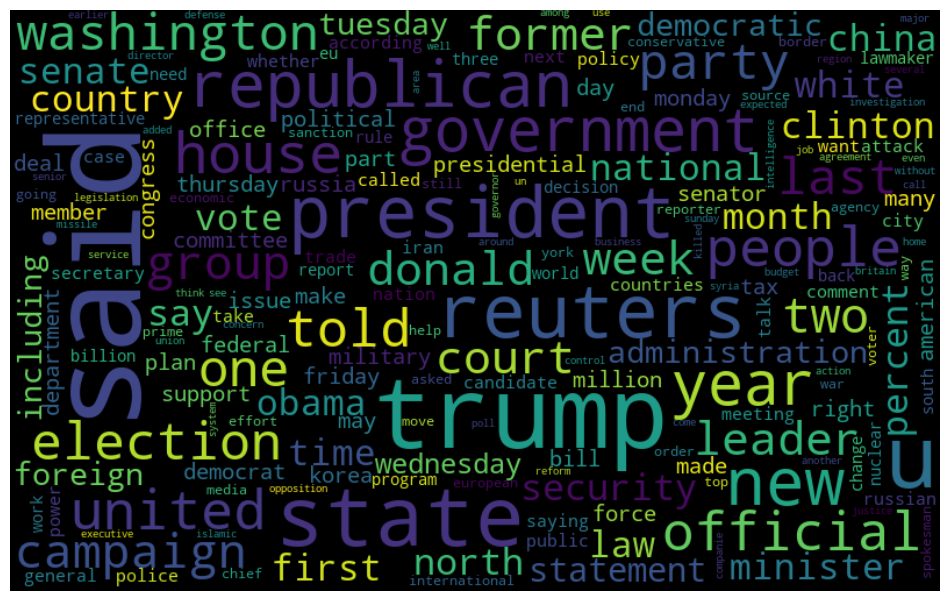

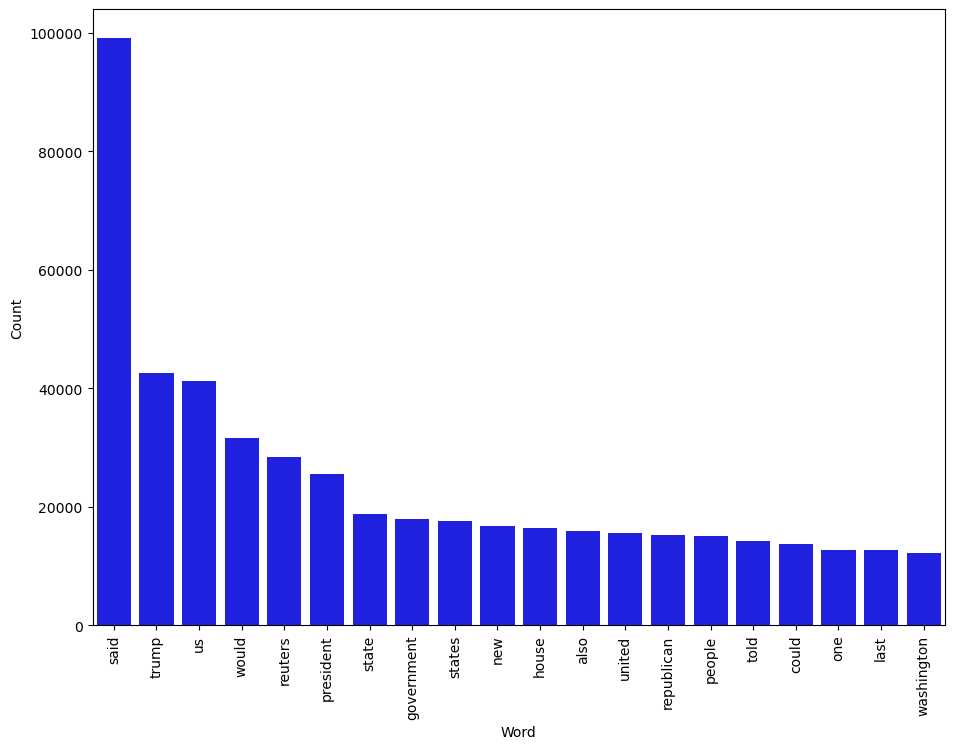

In [18]:
# Word cloud and most frequent words for real news
text = " ".join(df[df["target"] == "real"]["text"].to_list())

show_wordcloud(text)
show_frequent_words(text, 20)

## Modeling

In [19]:
# Vectorizing and applying TF-IDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline


def generate_model(model, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ("vectorizer", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("model", model)
    ])

    # Fitting the model
    model = pipeline.fit(X_train, y_train)

    # Checking accuracy
    y_pred = model.predict(X_test)
    print("Accuracy: {}%".format(round(accuracy_score(y_test, y_pred) * 100, 2)))

    # Plotting confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        normalize=None,
        display_labels=["Fake", "Real"],
        cmap=plt.cm.Blues
    )
    disp.ax_.set_title("Confusion matrix, without normalization")

### Peparing the data

In [20]:
# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["text"], df.target, test_size=0.2, random_state=42)

### Logistic Regression

Accuracy: 98.96%


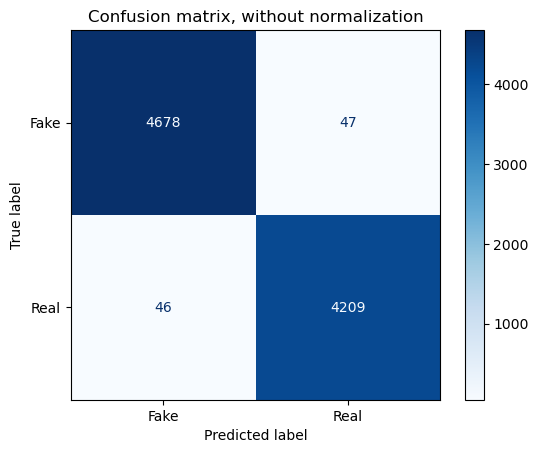

In [21]:
from sklearn.linear_model import LogisticRegression

generate_model(
    LogisticRegression(),
    X_train, X_test, y_train, y_test
)

### Decision Tree Classifier

Accuracy: 99.5%


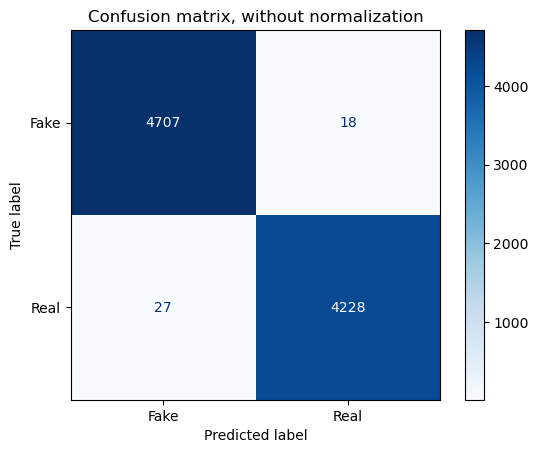

In [22]:
from sklearn.tree import DecisionTreeClassifier

generate_model(
    DecisionTreeClassifier(
        criterion="entropy",
        max_depth=20,
        splitter="best",
        random_state=42
    ),
    X_train, X_test, y_train, y_test
)

### Random Forest Classifier

Accuracy: 98.67%


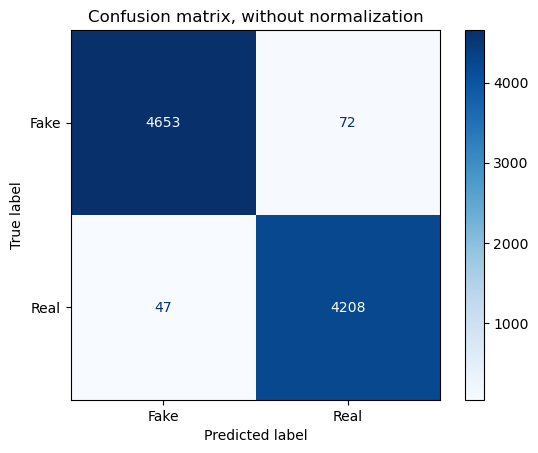

In [23]:
from sklearn.ensemble import RandomForestClassifier

generate_model(
    RandomForestClassifier(
        n_estimators=50,
        criterion="entropy"
    ),
    X_train, X_test, y_train, y_test
)